## 5.7　专题：支持向量机

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 用Seaborn画图
import seaborn as sns; sns.set()

### 5.7.1　支持向量机的由来
* 生成分类方法: 首先对每个类进行了随机分布的假设，然后用生成的模型估计新数据点的标签。
* 判别分类方法：不再为每类数据建模，而是用一条分割线（二维空间中的直线或曲线）或者流形体（多维空间中的曲线、曲面等概念的推广）将各种类型分割开。

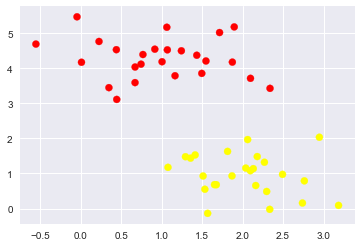

In [2]:
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

一个问题：在这两种类型之间，有不止一条直线可以将它们完美分割。

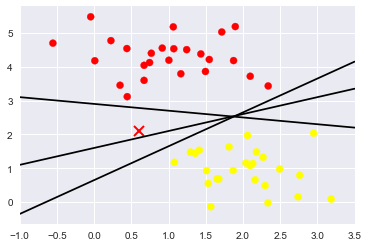

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
# 红色的X
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

虽然这三个不同的分割器都能完美地判别这些样本，但是选择不同的分割线，可能会让新的数据点（例如图5-54 中的“X”点）分配到不同的标签。显然，“画一条分割不同类型的直线”还不够，我们需要进一步思考。

### 5.7.2　支持向量机：边界最大化
支持向量机提供了改进这个问题的方法，它直观的解释是：**不再画一条细线来区分类型，而是画一条到最近点边界、有宽度的线条**。具体形式如下面的示例所示（如图5-55 所示）：

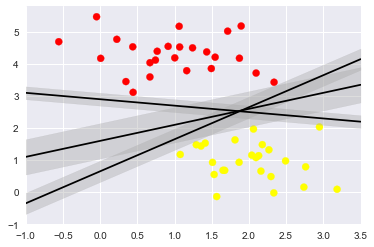

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA',
                     alpha=0.4)

plt.xlim(-1, 3.5);

在支持向量机中，选择边界最大的那条线是模型最优解。支持向量机其实就是一个边界最大化评估器。

#### 1. 拟合支持向量机
来看看这个数据的真实拟合结果：用Scikit-Learn 的支持向量机分类器在数据上训练一个SVM 模型。
<br>这里用一个线性核函数，并将参数C 设置为一个很大的数（后面会介绍这些设置的意义）：

In [5]:
from sklearn.svm import SVC # "Support vector classifier"

model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

为了实现更好的可视化分类效果，创建一个辅助函数画出SVM 的决策边界（如图5-56所示）：

In [7]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """画二维SVC的决策函数"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 创建评估模型的网格
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # 画决策边界和边界
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # 画支持向量
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

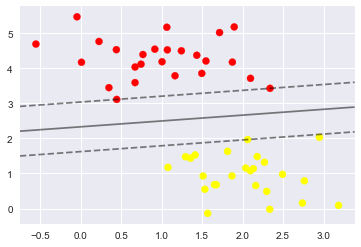

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

这就是两类数据间隔最大的分割线。你会发现有一些点正好就在边界线上，在图5-56 中用黑圆圈表示。这些点是拟合的关键支持点，被称为**支持向量**，支持向量机算法也因此得名。

**在Scikit-Learn 里面，支持向量的坐标存放在分类器的support_vectors_ 属性中**：

In [9]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

分类器能够成功拟合的关键因素，就是这些支持向量的位置——任何在正确分类一侧远离边界线的点都不会影响拟合结果！从技术角度解释的话，是因为这些点不会对拟合模型的损失函数产生任何影响，所以只要它们没有跨越边界线，它们的位置和数量就都无关紧要。

例如，可以分别画出数据集前60个点和前120个点的拟合结果，并进行对比（如图5-57所示）：

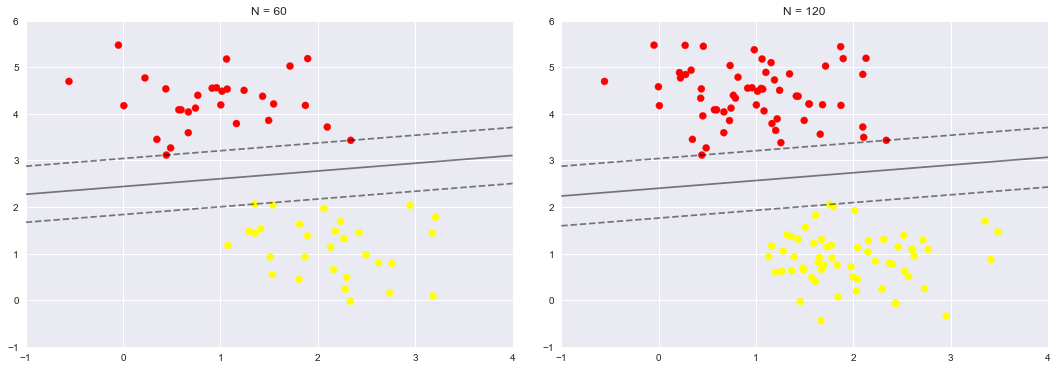

In [10]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=N, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

我们在左图中看到的是前60 个训练样本的模型和支持向量。在右图中，虽然我们画了前120 个训练样本的支持向量，但是模型并没有改变：左图中的3 个支持向量仍然适用于右图。这种对远离边界的数据点不敏感的特点正是SVM 模型的优点之一。

如果你正在运行Notebook，可以用IPython 的交互组件动态观察SVM 模型的这个特点（如图5-58 所示）：

In [11]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

#### 2. 超越线性边界：核函数SVM模型
将SVM 模型与核函数组合使用，功能会非常强大。我们在5.6 节介绍基函数回归时介绍过一些核函数。那时，我们将数据投影到多项式和高斯基函数定义的高维空间中，从而实现用线性分类器拟合非线性关系。

在SVM 模型中，我们可以沿用同样的思路。为了应用核函数，引入一些非线性可分的数据（如图5-59 所示）：

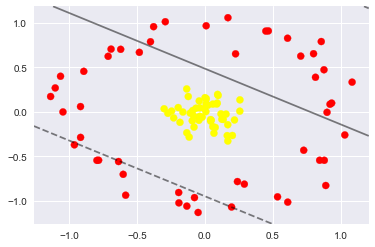

In [12]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

显然，这里需要用非线性判别方法来分割数据。回顾一下5.6 节介绍的基函数回归方法，想想如何将数据投影到高维空间，从而使线性分割器可以派上用场。例如，一种简单的投影方法就是计算一个以数据圆圈（middle clump）为中心的径向基函数：

In [13]:
r = np.exp(-(X ** 2).sum(1))

可以通过三维图来可视化新增的维度——如果你正在运行Notebook，就可以用滑块变换观察角度（如图5-60 所示）：

In [14]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

增加新维度之后，数据变成了线性可分状态。如果现在画一个分割平面，例如r = 0.7，即可将数据分割。

我们还需要仔细选择和优化投影方式；如果不能将径向基函数集中到正确的位置，那么就得不到如此干净、可分割的结果。通常，选择基函数比较困难，我们需要让模型自动指出最合适的基函数。

一种策略是**计算基函数在数据集上每个点的变换结果，让SVM 算法从所有结果中筛选出最优解**。这种基函数变换方式被称为**核变换**，是基于每对数据点之间的相似度（或者核函数）计算的。

这种策略的问题是，如果将N 个数据点投影到N 维空间，当N 不断增大的时候就会出现维度灾难，计算量巨大。但由于[核函数技巧](http://bit.ly/2fStZeA)提供的小程序可以隐式计算核变换数据的拟合，也就是说，不需要建立完全的N 维核函数投影空间！这个核函数技巧内置在SVM 模型中，是使SVM 方法如此强大的充分条件。

在Scikit-Learn 里面，我们可以应用核函数化的SVM 模型将线性核转变为RBF（径向基函数）核，设置kernel 模型超参数即可（如图5-61 所示）：

In [15]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

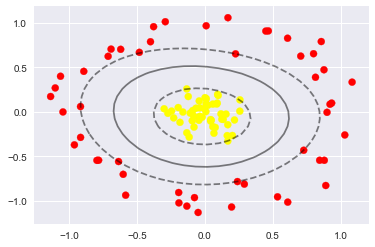

In [16]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

通过使用这个核函数化的支持向量机，我们找到了一条合适的非线性决策边界。在机器学习中，核变换策略经常用于将快速线性方法变换成快速非线性方法，尤其是对于那些可以应用核函数技巧的模型。

#### 3. SVM优化：软化边界
到目前为止，我们介绍的模型都是在处理非常干净的数据集，里面都有非常完美的决策边界。但如果你的数据有一些重叠该怎么办呢？例如，有如下所示一些数据（如图5-62所示）：

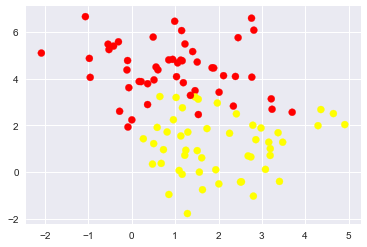

In [17]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

为了解决这个问题，SVM 实现了一些修正因子来“软化”边界。为了取得更好的拟合效果，它允许一些点位于边界线之内。边界线的硬度可以通过超参数进行控制，通常是C。
* 如果C 很大，边界就会很硬，数据点便不能在边界内“生存”；
* 如果C 比较小，边界线比较软，有一些数据点就可以穿越边界线。

图5-63 显示了不同参数C 通过软化边界线，对拟合效果产生的影响：

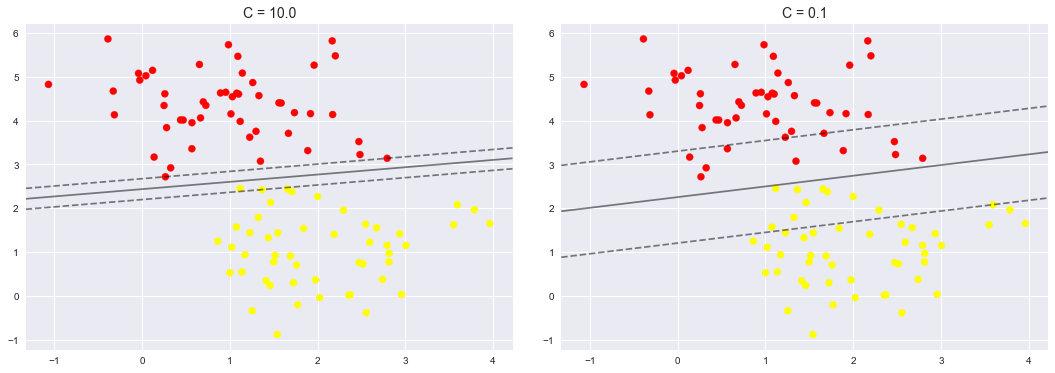

In [18]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

参数C 的最优值视数据集的具体情况而定，通过交叉检验或者类似的程序进行计算（详情请参见5.3 节）。

### 5.7.3　案例：人脸识别
我们用人脸识别案例来演示支持向量机的实战过程。这里用Wild 数据集中带标记的人脸图像，里面包含了数千张公开的人脸照片。Scikit-Learn 内置了获取照片数据集的功能：

In [37]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


画一些人脸，看看需要处理的数据（如图5-64 所示）：

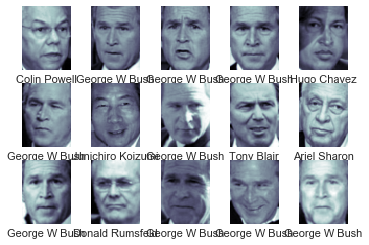

In [23]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

每个图像包含[62×47]、接近3000 像素。虽然可以简单地将每个像素作为一个特征，但是更高效的方法通常是使用预处理器来提取更有意义的特征。这里使用主成分分析（详情请参见5.9 节）来提取150 个基本元素，然后将其提供给支持向量机分类器。可以将这个预处理器和分类器打包成管道：

In [33]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(svd_solver='randomized', n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

为了测试分类器的训练效果，将数据集分解成训练集和测试集进行交叉检验：

In [34]:
from sklearn.cross_validation import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

最后，用网格搜索交叉检验来寻找最优参数组合。通过不断调整参数C（控制边界线的硬度）和参数gamma（控制径向基函数核的大小），确定最优模型：

In [35]:
from sklearn.grid_search import GridSearchCV

param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

Wall time: 36.3 s
{'svc__C': 10, 'svc__gamma': 0.001}


最优参数最终落在了网格的中间位置。如果它们落在了边缘位置，我们可能就需要扩展网格搜索范围，确保最优参数可以被搜索到。

有了交叉检验的模型，现在就可以对测试集的数据进行预测了：

In [28]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

将一些测试图片与预测图片进行对比（如图5-65 所示）：
<br>上面的某步把图片展平了

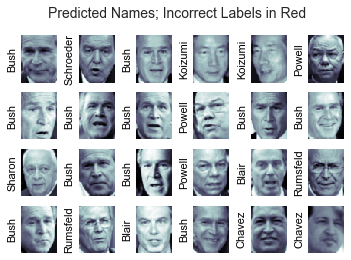

In [36]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

在这个小样本中，我们的最优评估器只判断错了一张照片（最后一行中布什的照片被误判为布莱尔）。我们可以打印分类效果报告，它会列举每个标签的统计结果，从而对评估器的性能有更全面的认识：

In [30]:
from sklearn.metrics import classification_report

print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.87      0.72        15
     Colin Powell       0.82      0.88      0.85        68
  Donald Rumsfeld       0.72      0.84      0.78        31
    George W Bush       0.98      0.81      0.89       126
Gerhard Schroeder       0.75      0.78      0.77        23
      Hugo Chavez       0.88      0.70      0.78        20
Junichiro Koizumi       0.80      1.00      0.89        12
       Tony Blair       0.83      0.95      0.89        42

      avg / total       0.86      0.85      0.85       337



还可以画出这些标签的混淆矩阵（如图5-66 所示）：

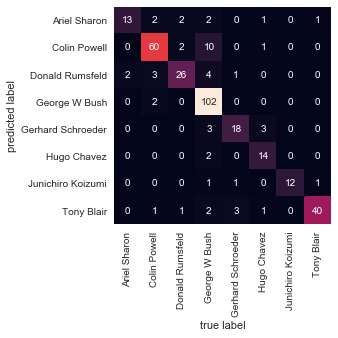

In [31]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, yfit)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

这幅图可以帮助我们清晰地判断哪些标签容易被分类器误判。

真实环境中的人脸识别问题的照片通常不会被切割得这么整齐（即使像素相同），两类人脸分类机制的唯一差别其实是特征选择：你需要用更复杂的算法找到人脸，然后提取图片中与像素化无关的人脸特征。这类问题有一个不错的解决方案，就是用[OpenCV](http://opencv.org)配合其他手段，包括最先进的通用图像和人脸图像的特征提取工具，来获取人脸特征数据。

### 5.7.4　支持向量机总结
前面已经简单介绍了支持向量机的基本原则。支持向量机是一种强大的分类方法，主要有四点理由。
* 模型依赖的支持向量比较少，说明它们都是非常精致的模型，消耗内存少。
* 一旦模型训练完成，预测阶段的速度非常快。
* 由于模型只受边界线附近的点的影响，因此它们对于高维数据的学习效果非常好——即使训练比样本维度还高的数据也没有问题，而这是其他算法难以企及的。
* 与核函数方法的配合极具通用性，能够适用不同类型的数据。但是，SVM 模型也有一些缺点。
* 随着样本量N 的不断增加，最差的训练时间复杂度会达到 [N3]；经过高效处理后，也只能达到 [N2]。因此，大样本学习的计算成本会非常高。
* 训练效果非常依赖于边界软化参数C 的选择是否合理。这需要通过交叉检验自行搜索；当数据集较大时，计算量也非常大。
* 预测结果不能直接进行概率解释。这一点可以通过内部交叉检验进行评估（具体请参见SVC 的probability 参数的定义），但是评估过程的计算量也很大。

由于这些限制条件的存在，我通常只会在其他简单、快速、调优难度小的方法不能满足需求时，才会选择支持向量机。但是，如果你的计算资源足以支撑SVM 对数据集的训练和交叉检验，那么用它一定能获得极好的效果。

In [40]:
faces.target_names[yfit[1]].split()[-1]

'Schroeder'